<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Based on https://github.com/deeptime-ml/deeptime-notebooks/blob/master/transition-counting.ipynb

In [44]:
import sys
import os

try:
    os.chdir(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup/molgri")
    sys.path.append(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup")
except FileNotFoundError:
    os.chdir(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    sys.path.append(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    
import warnings
warnings.filterwarnings("ignore")

In [48]:
import numpy as np
from deeptime.markov import TransitionCountEstimator
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from molgri.molecules.transitions import SimulationHistogram
from molgri.space.fullgrid import FullGrid


The process I use for creating a MSM:
1) assign the trajectory to discrete states using SimulationHistogram and get_full_assignments()

2) build a  count estimator with TransitionCountEstimator

3) get a TransitionCountModel with NXN states by fitting assignments to an estimator

4) now build a MaximumLikelihoodMSM estimator

5) fit a TransitionCountModel to it to obtain MarkovStateModel

The whole process can be repeated for different values of tau.

In [ ]:
# 1) assign the trajectory to discrete states using SimulationHistogram and get_full_assignments()
water_sh = SimulationHistogram("H2O_H2O_0095_30000000", "H2O", is_pt=False,
                                   full_grid=FullGrid(b_grid_name="42", o_grid_name="40",
                                                      t_grid_name="linspace(0.2, 0.6, 40)"),
                                   second_molecule_selection="bynum 4:6", use_saved=True)
assignments = water_sh.get_full_assignments()


# 2) build a  count estimator with TransitionCountEstimator
count_estimator = TransitionCountEstimator(
    lagtime=20,
    count_mode="sliding",
    n_states=len(water_sh.full_grid),
    sparse=False
)

# 3) get a TransitionCountModel with NXN states by fitting assignments to an estimator
count_model = count_estimator.fit(assignments).fetch_model()


# 4) now build a MaximumLikelihoodMSM estimator
estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True,
                                         sparse=False,
                                        )

# 5) fit a TransitionCountModel to it to obtain MarkovStateModel
markov_model = estimator.fit_from_counts(count_model).fetch_model()

In [ ]:
def get_markov_model_for_taus(tau_array, assignments, len_fullgrid):
    all_msms = []
    for tau in tau_array:
        # 2) build a  count estimator with TransitionCountEstimator
        count_estimator = TransitionCountEstimator(lagtime=tau, count_mode="sliding",
                                                   n_states=len_fullgrid, sparse=False)

        # 3) get a TransitionCountModel with NXN states by fitting assignments to an estimator
        count_model = count_estimator.fit(assignments).fetch_model()


        # 4) now build a MaximumLikelihoodMSM estimator
        estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True,
                                                 sparse=False,
                                                )

        # 5) fit a TransitionCountModel to it to obtain MarkovStateModel
        markov_model = estimator.fit_from_counts(count_model).fetch_model()
        
        all_msms.append(markov_model)
    return all_msms

In [ ]:
taus = np.array([70, 80, 90, 100, 110, 130, 150, 180, 200, 220,
                          250, 270, 300, 400, 600, 700, 850, 1000
                             , 1100, 1200, 1300, 1400, 1500,
                          2000, 3000, 4000, 5000, 7000, 10000], dtype=int)
msms = get_markov_model_for_taus(tau_array=taus, assignments=assignments, len_fullgrid=len(water_sh.full_grid))

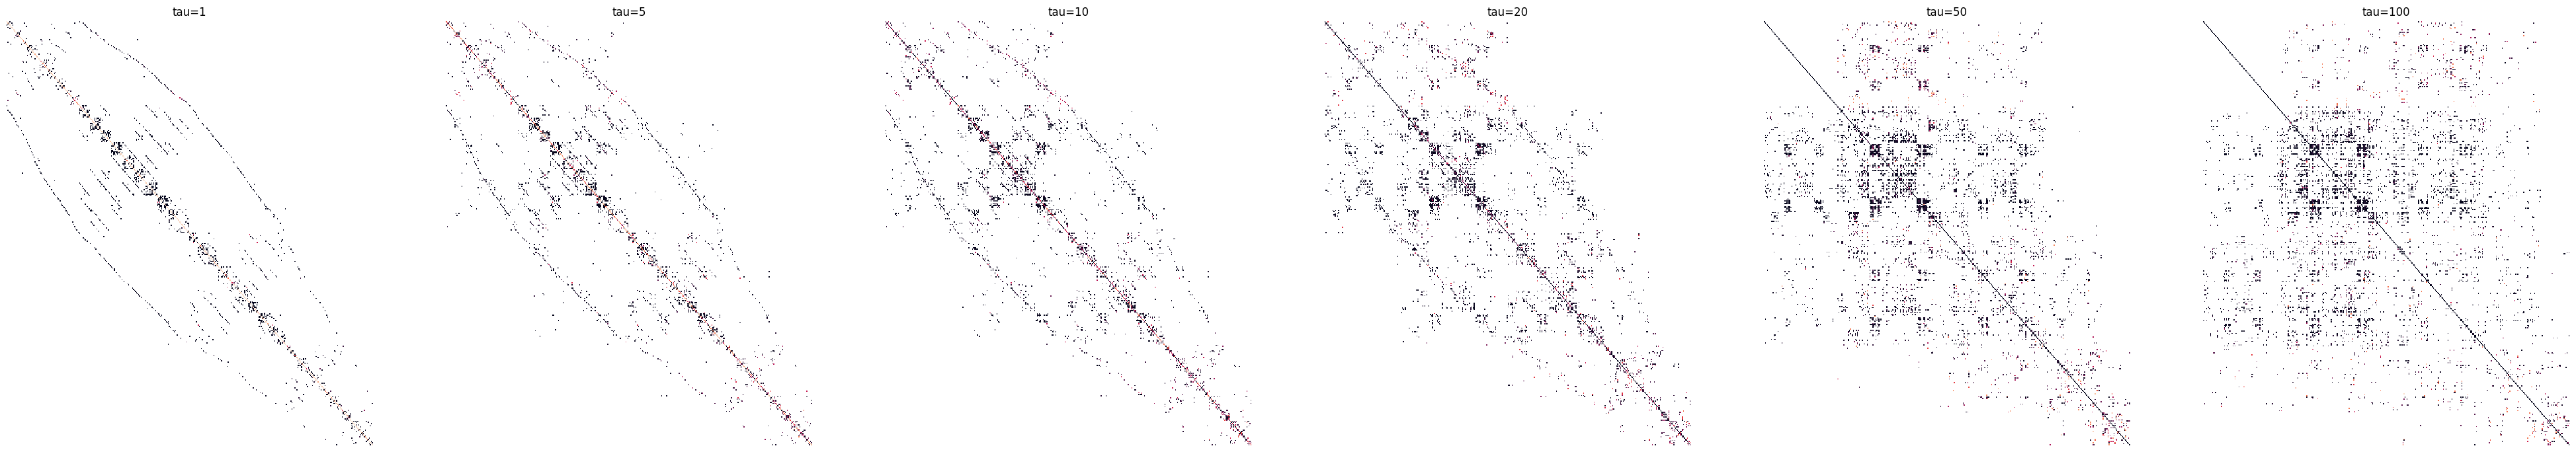

In [87]:
display_taus = [0, 6, 14, 22, len(taus)]
fig, ax = plt.subplots(1, len(display_taus),figsize=(10, 10/len(display_taus)))
for i, dt in enumerate(display_taus):
    tm = msms[i].transition_matrix
    sns.heatmap(tm, mask=tmx==0, ax=ax[i], cbar=False, xticklabels=[], yticklabels=[])
    ax[i].set_title(f"tau={dt}")
plt.show()

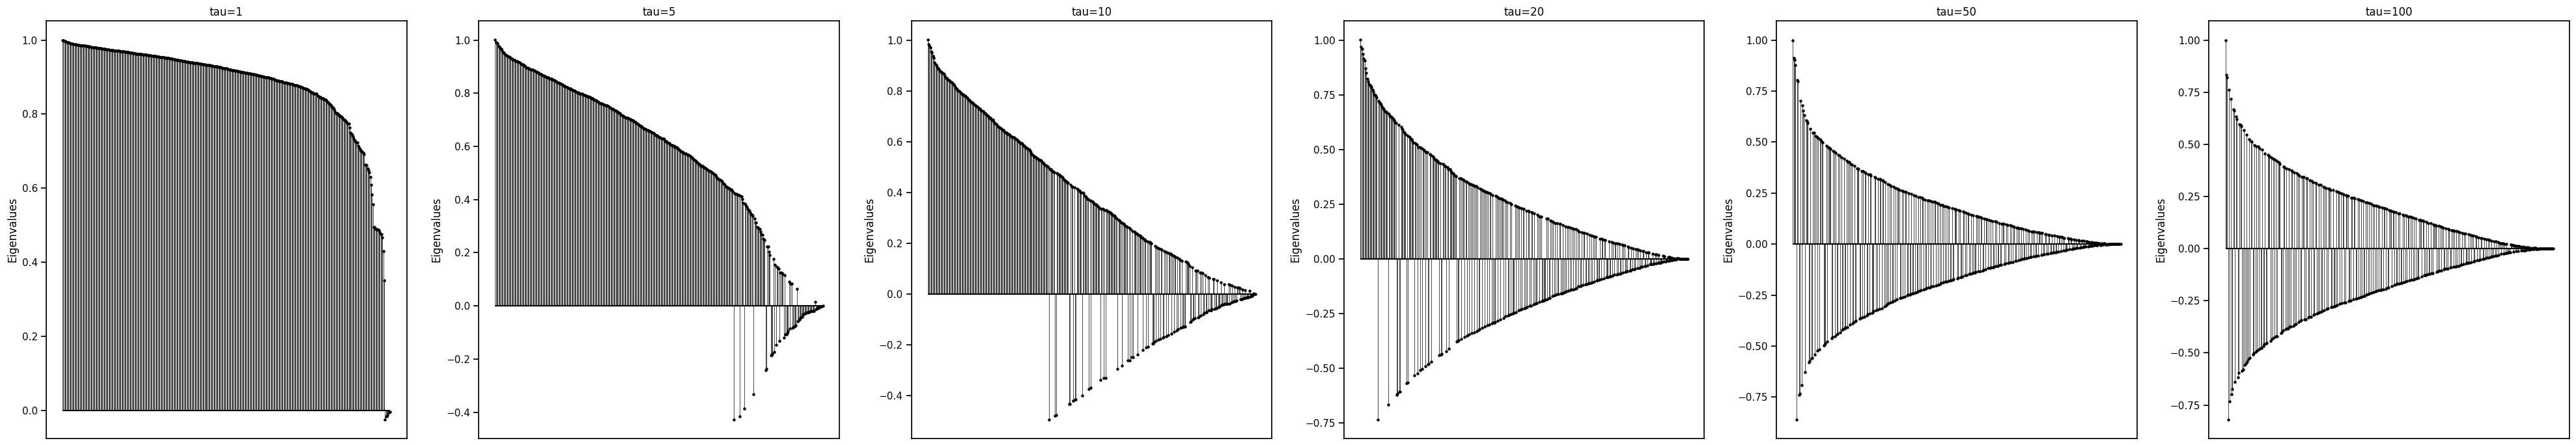

In [92]:
def plot_eigenvalues(eigenvals, ax):
    xs = np.linspace(0, 1, num=len(eigenvals))
    ax.scatter(xs, eigenvals, s=5, c="black")
    for i, eigenw in enumerate(eigenvals):
        ax.vlines(xs[i], eigenw, 0, linewidth=0.5, color="black")
    ax.hlines(0, 0, 1, color="black")
    ax.set_ylabel(f"Eigenvalues")
    ax.axes.get_xaxis().set_visible(False)

fig, ax = plt.subplots(1, len(display_taus),figsize=(10, 10/len(display_taus)))
for i, dt in enumerate(display_taus):
    plot_eigenvalues(msms[i].eigenvalues(), ax[i])
    ax[i].set_title(f"tau={dt}")
plt.show()

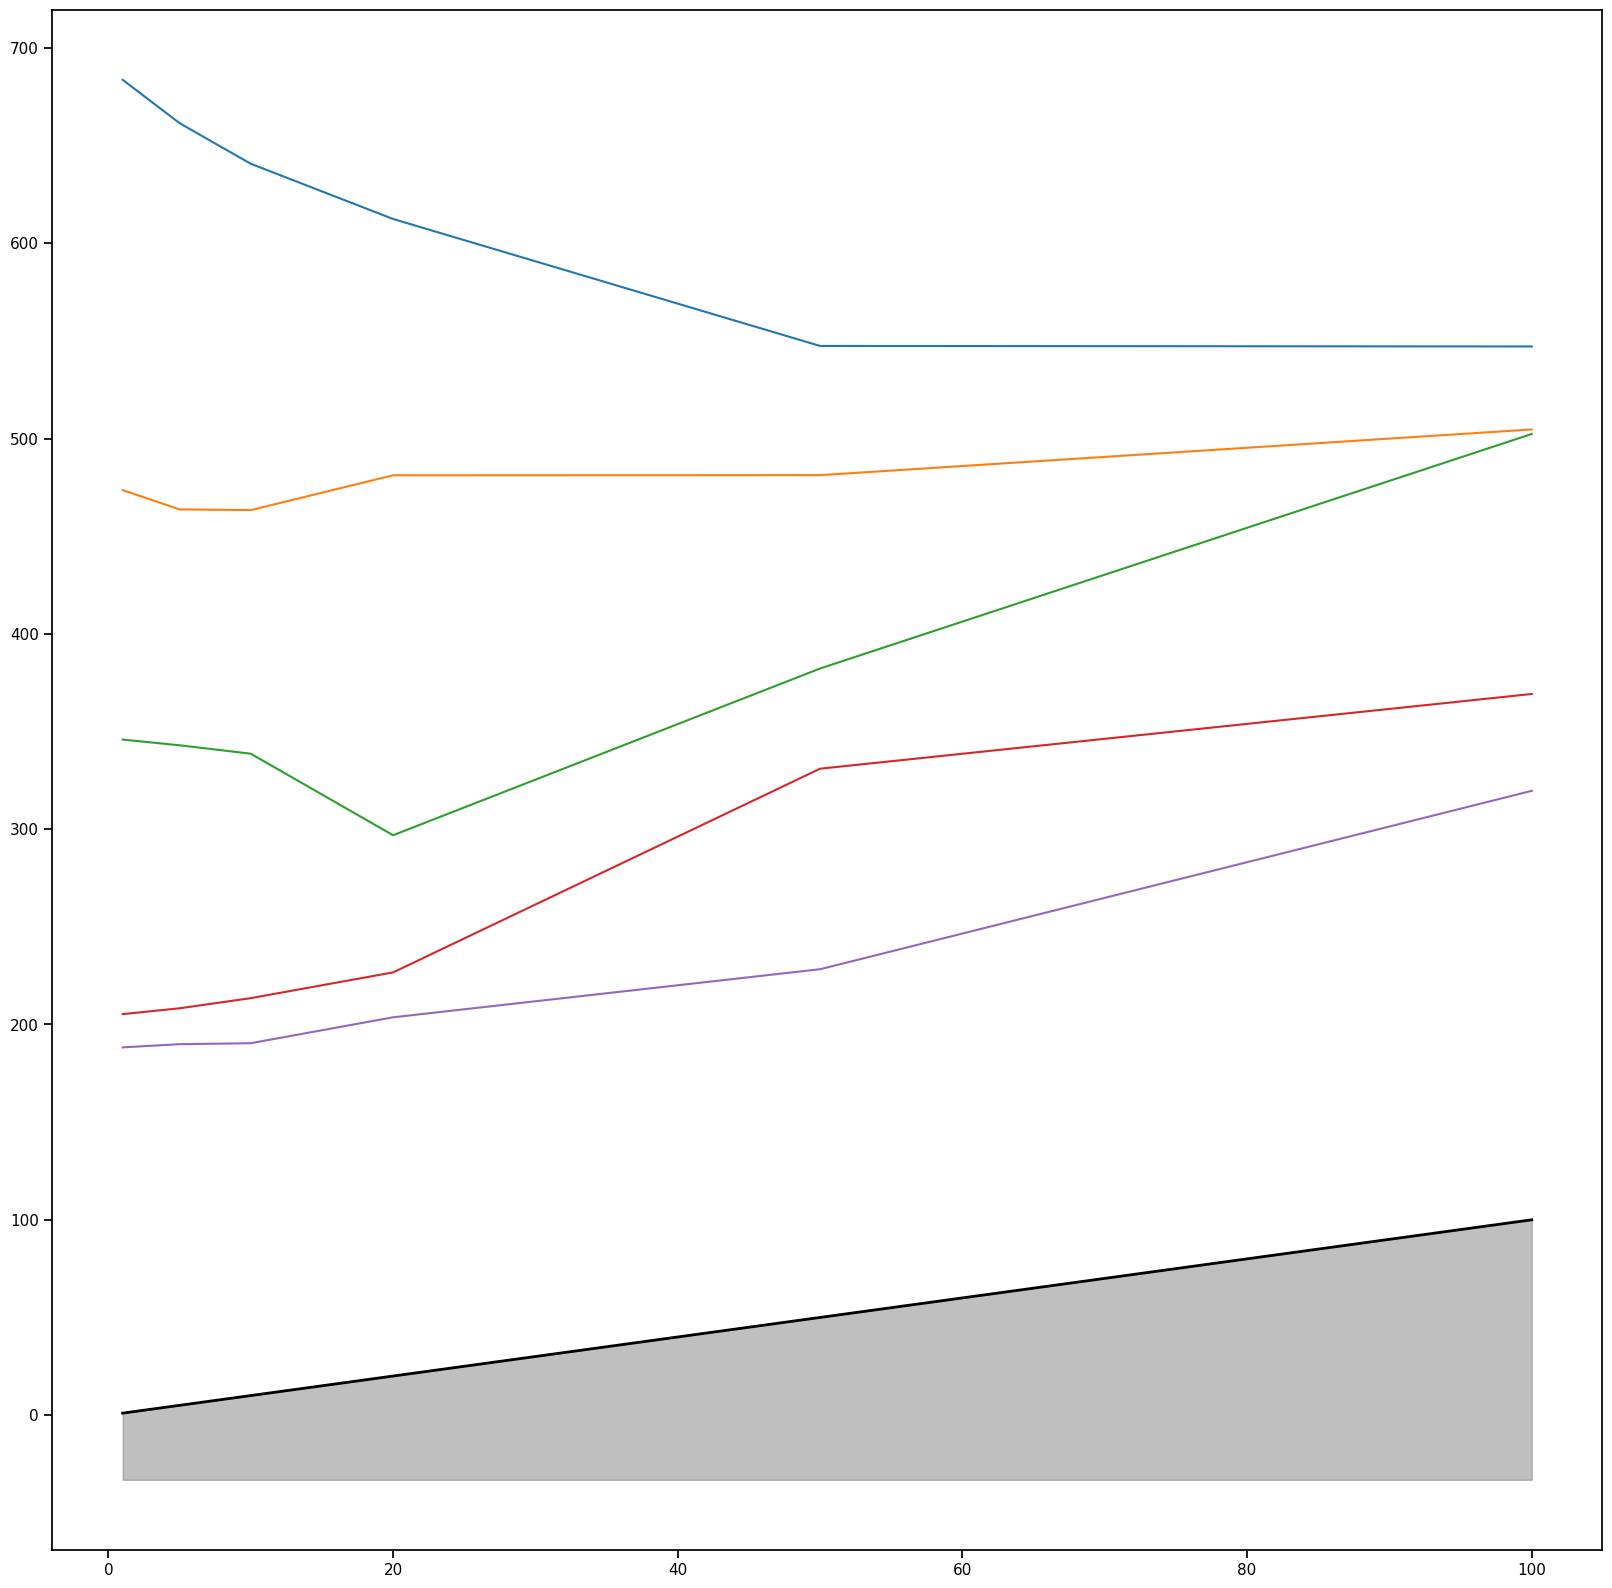

In [101]:
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import ImpliedTimescales



fig, ax = plt.subplots(1, 1, figsize=(10, 10))

its = ImpliedTimescales(lagtimes=taus, its=[msm.timescales(k=5) for msm in msms])
plot_implied_timescales(data=its, ax=ax)
plt.show()



In [ ]:
def plot_one_eigenvector_flat(eigenvector):
    eigenvals, eigenvecs = self.transition_obj.get_eigenval_eigenvec()

    # shape: (number_taus, number_cells, num_eigenvectors)
    eigenvecs = eigenvecs[index_tau]  # values for the first tau
    sns.lineplot(eigenvecs.T[eigenvec_index], ax=self.ax)
    self.ax.set_title(f"Eigenv. {eigenvec_index}")
    

fig, ax = plt.subplots(1, len(display_taus),figsize=(10, 10/len(display_taus)))
for i, dt in enumerate(display_taus):
    plot_eigenvalues(msms[i].eigenvalues(), ax[i])
    ax[i].set_title(f"tau={dt}")
plt.show()